In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
#image preprocessing (cv2.resize alternatives: tf.image.resize & PIL Image.resize)
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#model
from tensorflow.keras.models import Sequential
#layers
from tensorflow.keras.layers import Dense, Flatten, Softmax, MaxPool2D, AveragePooling2D, Conv2D, BatchNormalization, Activation, InputLayer, Rescaling
#regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1,l2,l1_l2, L1L2
#optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


In [ ]:
#run only in case of image resize requirement
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> uncomment lines below before running <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#input_dir1 = '/content/drive/MyDrive/vbm689/sahagozu/collapsed'
#output_dir1 = '/content/drive/MyDrive/vbm689/resized/collapsed'
#input_dir2 = '/content/drive/MyDrive/vbm689/sahagozu/damaged'
#output_dir2 = '/content/drive/MyDrive/vbm689/resized/damaged'

img_size = (256, 192)

def imageResize(input_dir, output_dir, img_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Rotate if necessary
            height, width = img.shape[:2]
            if height > width:
                img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                height, width = width, height

            # Padding
            aspect_ratio = height / width
            target_ratio = img_size[1] / img_size[0]

            if aspect_ratio != target_ratio:
              if aspect_ratio > target_ratio:
                # Pad horizontally
                new_width = int(height / target_ratio)
                pad = (new_width - width) // 2
                pad_left = pad
                pad_right = new_width - width - pad
                pad_top = 0
                pad_bottom = 0
                img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, (0, 0, 0))
              elif aspect_ratio < target_ratio:
                # Pad vertically
                new_height = int(width * target_ratio)
                pad2 = (new_height - height) // 2
                pad2_top = pad2
                pad2_bottom = new_height - height - pad2
                pad2_left = 0
                pad2_right = 0
                img = cv2.copyMakeBorder(img, pad2_top, pad2_bottom, pad2_left, pad2_right, cv2.BORDER_CONSTANT, (0, 0, 0))

            # Resize image
            img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

            # Save image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, img)


imageResize(input_dir1,output_dir1,img_size)

imageResize(input_dir2,output_dir2,img_size)

def LearnSize(directory):
  dimensions = set()
  count = 0
  for filename in os.listdir(directory):
      if filename.endswith('.jpg'):
          count += 1
          filepath = os.path.join(directory, filename)
          with Image.open(filepath) as img:
              width, height = img.size
              dimensions.add((width, height))

  print('Unique image dimensions of '+ directory)
  for dim in dimensions:
      print(f'{dim[0]}x{dim[1]}')
  print("Total number of files:", count)
#to check the image size
LearnSize(output_dir1)
LearnSize(output_dir2)

In [ ]:
# resized images are reformatted with random selected 10% for testing & 90% for training
#Training will be further divided into 13.5% validation and 76.5% training (with validation_split=0.15)

# Set the path for the data directory
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> uncomment lines below before running <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#data_dir = '/content/drive/MyDrive/vbm689/resized/'
#output_dir = '/content/drive/MyDrive/vbm689/reformatted/'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create the train and test directories within the output directory
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create collapsed and damaged directories within train and test directories
train_collapsed_dir = os.path.join(train_dir, 'collapsed')
train_damaged_dir = os.path.join(train_dir, 'damaged')
test_collapsed_dir = os.path.join(test_dir, 'collapsed')
test_damaged_dir = os.path.join(test_dir, 'damaged')

if not os.path.exists(train_collapsed_dir):
    os.makedirs(train_collapsed_dir)

if not os.path.exists(train_damaged_dir):
    os.makedirs(train_damaged_dir)

if not os.path.exists(test_collapsed_dir):
    os.makedirs(test_collapsed_dir)

if not os.path.exists(test_damaged_dir):
    os.makedirs(test_damaged_dir)

# Get the list of collapsed and damaged files
collapsed_files = os.listdir(os.path.join(data_dir, 'collapsed'))
damaged_files = os.listdir(os.path.join(data_dir, 'damaged'))

# Calculate the number of files for test and train sets (10% for test, 90% for train)
test_size_collapsed = int(len(collapsed_files) * 0.1)
test_size_damaged = int(len(damaged_files) * 0.1)

# Randomly select test_size number of files from collapsed and damaged folders
collapsed_test_files = random.sample(collapsed_files, test_size_collapsed)
damaged_test_files = random.sample(damaged_files, test_size_damaged)

# Copy the selected test files to the test directories
for file in collapsed_test_files:
    src = os.path.join(data_dir, 'collapsed', file)
    dst = os.path.join(test_collapsed_dir, file)
    shutil.copyfile(src, dst)

for file in damaged_test_files:
    src = os.path.join(data_dir, 'damaged', file)
    dst = os.path.join(test_damaged_dir, file)
    shutil.copyfile(src, dst)

# Copy the remaining files to the train directories
for file in collapsed_files:
    if file not in collapsed_test_files:
        src = os.path.join(data_dir, 'collapsed', file)
        dst = os.path.join(train_collapsed_dir, file)
        shutil.copyfile(src, dst)

for file in damaged_files:
    if file not in damaged_test_files:
        src = os.path.join(data_dir, 'damaged', file)
        dst = os.path.join(train_damaged_dir, file)
        shutil.copyfile(src, dst)

# Count the number of files in each folder
train_collapsed_count = len(os.listdir(train_collapsed_dir))
train_damaged_count = len(os.listdir(train_damaged_dir))
test_collapsed_count = len(os.listdir(test_collapsed_dir))
test_damaged_count = len(os.listdir(test_damaged_dir))

# Print the file counts
print("Number of files in reformatted/train/collapsed:", train_collapsed_count)
print("Number of files in reformatted/train/damaged:", train_damaged_count)
print("Number of files in reformatted/test/collapsed:", test_collapsed_count)
print("Number of files in reformatted/test/damaged:", test_damaged_count)

Number of files in reformatted/train/collapsed: 696
Number of files in reformatted/train/damaged: 494
Number of files in reformatted/test/collapsed: 77
Number of files in reformatted/test/damaged: 54


In [4]:
# Set the path for the data directory
data_dir_train = '/content/drive/MyDrive/vbm689/reformatted/train'
data_dir_test = '/content/drive/MyDrive/vbm689/reformatted/test'

# Set the input image size and batch size
img_height = 192
img_width = 256
batch_size = 64

# Create an instance of the ImageDataGenerator class for data preprocessing
datagen = ImageDataGenerator(#rescale=1./255,
    validation_split=0.15,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Generate the training dataset
train_ds = datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=42
)

# Generate the validation dataset
val_ds = datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=42
)

# Generate the test dataset
test_ds = datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

Found 1012 images belonging to 2 classes.
Found 178 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [ ]:
print (train_ds.class_indices)
print(train_ds.image_shape)
print (val_ds.class_indices)
print(val_ds.image_shape)
print (test_ds.class_indices)
print(test_ds.image_shape)

{'collapsed': 0, 'damaged': 1}
(192, 256, 3)
{'collapsed': 0, 'damaged': 1}
(192, 256, 3)
{'collapsed': 0, 'damaged': 1}
(192, 256, 3)


In [8]:
def get_mlp_model():
  model = Sequential();
  model.add(Rescaling(scale = 1./255, input_shape = (img_height,img_width,3))) # input layer
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2()))  # hidden layer
  model.add(Dropout(rate=0.2))
  model.add(Dense(128,activation='relu'))#, kernel_regularizer=l2(),bias_regularizer=l2()))  # hidden layer
  model.add(Dense(32,activation='relu'))#, kernel_regularizer=l2(),bias_regularizer=l2()))  # hidden layer
  model.add(Dense(8,activation='relu'))#, kernel_regularizer=l2(),bias_regularizer=l2()))  # hidden layer
  model.add(Dropout(rate=0.25))
  model.add(Dense(1,activation='sigmoid'))  # final layer
  model.compile(optimizer=SGD(learning_rate=0.001),loss='binary_crossentropy' ,metrics=['accuracy'])
  return model


def get_cnn_model():
    model = Sequential()
    model.add(Rescaling(scale = 1./255, input_shape = (img_height,img_width,3))) # input layer

    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid'))#, kernel_regularizer=l2(), bias_regularizer=l2() ))
    #model.add(BatchNormalization())
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='valid'))#, kernel_regularizer=l2(), bias_regularizer=l2() ))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='valid'))#, kernel_regularizer=l2(), bias_regularizer=l2() ))
    model.add(Conv2D(256, kernel_size=3, activation='relu', padding='valid'))#, kernel_regularizer=l2(), bias_regularizer=l2() ))
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='valid'))#, kernel_regularizer=l2(), bias_regularizer=l2() ))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))#, kernel_regularizer=l2(), bias_regularizer=l2()))
    model.add(Dropout(0.25))
    model.add(Dense(1024,activation='relu'))#, kernel_regularizer=l2(), bias_regularizer=l2()))
    model.add(Dropout(0.25))
    model.add(Dense(2,activation='softmax')) # final layer
    model.compile(optimizer=SGD(learning_rate=0.01),loss='sparse_categorical_crossentropy' ,metrics=['accuracy'])
    return model

def get_vgg16_model():
  base_model = tf.keras.applications.VGG16(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.vgg16.preprocess_input
  base_model.trainable = False
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  hidden_layer = Dense(256, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())
  hidden_layer_2 = Dense(256, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())
  dropout_layer = Dropout(0.2)
  prediction_layer = Dense(1,activation='sigmoid')
  #
  inputs = tf.keras.Input(shape=(img_height,img_width,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = dropout_layer(x)
  x = hidden_layer(x)
  x = hidden_layer_2(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #
  model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy' ,metrics=['accuracy'])
  return model

def get_xception_model():
  base_model = tf.keras.applications.Xception(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.xception.preprocess_input
  base_model.trainable = False
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  hidden_layer = Dense(256, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())
  hidden_layer_2 = Dense(256, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())
  dropout_layer = Dropout(0.2)
  prediction_layer = Dense(1,activation='sigmoid')
  #
  inputs = tf.keras.Input(shape=(img_height,img_width,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = dropout_layer(x)
  x = hidden_layer(x)
  x = hidden_layer_2(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #
  model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy' ,metrics=['accuracy'])
  return model

def get_mobilenetv2_model():
  base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height,img_width,3), include_top=False, weights='imagenet')
  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
  base_model.trainable = False
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  hidden_layer = Dense(256, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())
  hidden_layer_2 = Dense(256, activation='relu', kernel_regularizer=l2(), bias_regularizer=l2())
  dropout_layer = Dropout(0.2)
  prediction_layer = Dense(1,activation='sigmoid')
  #
  inputs = tf.keras.Input(shape=(img_height,img_width,3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = dropout_layer(x)
  x = hidden_layer(x)
  x = hidden_layer_2(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #
  model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy' ,metrics=['accuracy'])
  return model

# early stopping
earlystopCB = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

model = get_mobilenetv2_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 192, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 192, 256, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [9]:
from keras.callbacks import EarlyStopping
history = model.fit(train_ds, epochs=50, validation_data=val_ds, batch_size=batch_size, callbacks=earlystopCB)

Epoch 1/50
16/16 [==============================] - 80s 5s/step - loss: 7.4115 - accuracy: 0.5988 - val_loss: 7.1577 - val_accuracy: 0.7416
Epoch 2/50
16/16 [==============================] - 70s 4s/step - loss: 7.0606 - accuracy: 0.7421 - val_loss: 6.8632 - val_accuracy: 0.8315
Epoch 3/50
16/16 [==============================] - 69s 4s/step - loss: 6.7669 - accuracy: 0.7885 - val_loss: 6.6173 - val_accuracy: 0.8371
Epoch 4/50
16/16 [==============================] - 66s 4s/step - loss: 6.5256 - accuracy: 0.8103 - val_loss: 6.3962 - val_accuracy: 0.8202
Epoch 5/50
16/16 [==============================] - 64s 4s/step - loss: 6.3025 - accuracy: 0.8192 - val_loss: 6.2050 - val_accuracy: 0.8427
Epoch 6/50
16/16 [==============================] - 64s 4s/step - loss: 6.0926 - accuracy: 0.8241 - val_loss: 5.9927 - val_accuracy: 0.8596
Epoch 7/50
16/16 [==============================] - 65s 4s/step - loss: 5.8970 - accuracy: 0.8192 - val_loss: 5.8597 - val_accuracy: 0.7978
Epoch 8/50
16/16 [==

In [12]:
model.evaluate(test_ds, return_dict=True)

3/3 [==============================] - 7s 1s/step - loss: 1.8344 - accuracy: 0.8855


{'loss': 1.8344234228134155, 'accuracy': 0.885496199131012}

Best Validation Loss: 1.9356
Best Validation Accuracy: 0.8596


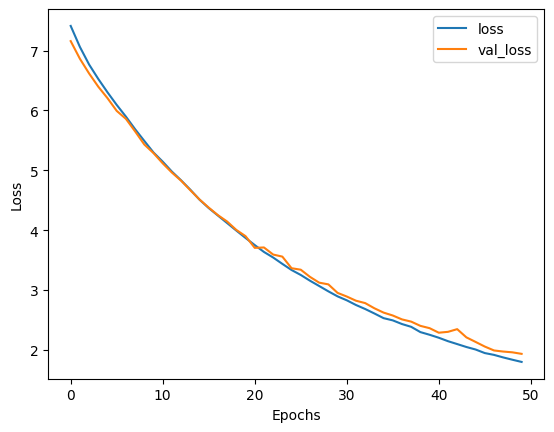

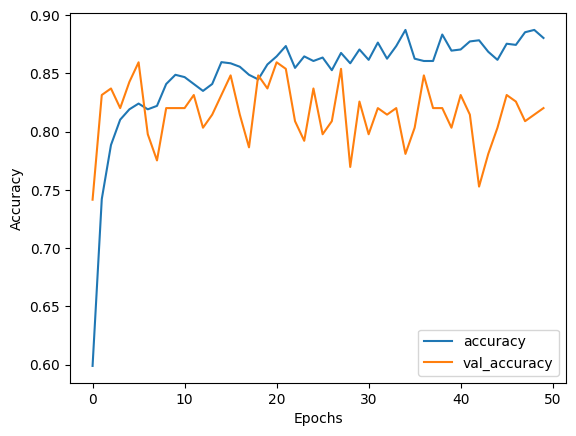

In [13]:
acc = history.history['accuracy']
history_df = pd.DataFrame(history.history)
loss_plot = history_df.loc[:, ['loss', 'val_loss']].plot()
loss_plot.set(xlabel='Epochs')
loss_plot.set(ylabel='Loss')
acc_plot = history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
acc_plot.set(xlabel='Epochs')
acc_plot.set(ylabel='Accuracy')

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [16]:
saved_model = '/content/drive/MyDrive/saved_model/'
if not os.path.exists(saved_model):
    os.makedirs(saved_model)
model.save('/content/drive/MyDrive/saved_model/mobilenetv2_model')
# new_model = tf.keras.models.load_model('saved_model/mobilenetv2_model')